In [115]:
import numpy as np
import matplotlib.pyplot as plt
from bresenham import bresenham
import imageio
import pydicom
from pydicom.data import get_testdata_files
from scipy import ndimage
from scipy.fftpack import fft, ifft, fftfreq

In [104]:
alfa = 1
n = 150
l = 90

In [106]:
"""
Obliczanie współrzędnych (x, y) i-tego z n emiterów na okręgu o promieniu r i rozpiętości l. 
Pamiętaj o tym, że środek okręgu jest środkiem obrazu (offset)
W przypadku układu z jednym emiterem, funkcja powinna być niezależna od i oraz n
Pamiętaj o ewentualnej konwersji stopnie -> radiany
http://www.cs.put.poznan.pl/swilk/pmwiki/uploads/Dydaktyka/tomograf-wzory.pdf
"""
def emiterPosition(angle, i, n, r, l, offset):
    x = r * np.cos( np.radians(angle) ) + offset[0]
    y = r * np.sin( np.radians(angle) ) + offset[1]
    return (x,y)

In [107]:
"""
Obliczanie współrzędnych (x, y) i-tego z n sensorów na okręgu o promieniu r i rozpiętości l.
Pamiętaj o tym, że środek okręgu jest środkiem obrazu (offset)
http://www.cs.put.poznan.pl/swilk/pmwiki/uploads/Dydaktyka/tomograf-wzory.pdf
"""
def sensorPosition(angle, i, n, r, l, offset):
    x = r * np.cos( np.radians(angle) + np.pi - np.radians(l)/2 + i * ( np.radians(l) / (n-1) ) ) + offset[0]
    y = r * np.sin( np.radians(angle) + np.pi - np.radians(l)/2 + i * ( np.radians(l) / (n-1) ) ) + offset[1]
    return (x,y)

In [108]:
"""
Symulacja laseru przechodzącego liniowo przez obraz image z punktu start do punktu end.
Należy policzyć, ile mocy lasera zostanie pochłonięte, skorzystaj z funkcji bresenham
"""
def beam(image, start, end):
    width, height = image.shape
    x = bresenham(int(start[0]), int(start[1]), int(end[0]), int(end[1]))
    y = np.array(list(x))
    y = y[y[:,0] >= 0]
    y = y[y[:,0] < width]
    y = y[y[:,1] >= 0]
    y = y[y[:,1] < height]
    return np.sum(image[y[:,0],y[:,1]])

In [109]:
def makeGif(gif, filename):
    scale = gif[-1].max()
    gif = list(map(lambda x: (x/scale*255).astype(np.uint8), gif))
    imageio.mimsave(filename+".gif", gif)

In [154]:
def radon_iwm(img_gray, alfa, n, l, R, gifFlag=True, filter=False):   
    gif = []
    gif_f = []
    result = np.zeros((n, len(np.arange(-90,90,alfa))))
    result_filtered = np.zeros((n, len(np.arange(-90,90,alfa))))
    for i,angle in enumerate(np.arange(-90,90,alfa)[::-1]):
        result[..., i] = np.array([beam(img_gray, 
                                         emiterPosition(angle, sensor, n, R, l, (img_gray.shape[1]/2, img_gray.shape[0]/2)),
                                         sensorPosition(angle, sensor, n, R, l, (img_gray.shape[1]/2, img_gray.shape[0]/2)))
                                   for sensor in range(n)])
        
        #if angle % 10 == 0:
         #   print(f"angle {angle}")
        if gifFlag:
            gif.append(result.copy())
    if gifFlag:
        makeGif(gif, "radon")
    if filter:
        sinogram = result.copy()
        f = fftfreq(sinogram.shape[0]).reshape(-1, 1)  # digital frequency
        fourier_filter = 2 * np.abs(f)  # ramp filter

        projection = fft(sinogram, axis=0) * fourier_filter
        sinogram = np.real(ifft(projection, axis=0))
        return sinogram/sinogram.max()
    return result/result.max()

In [176]:
def inverseRadon_iwn(radon, shape, alfa, n, l, R, gifFlag=True, filter=False):
    width, height = shape
    gif = []
    result = np.zeros(shape)
    R = max(shape)*2**.5+10
    for i, angle in enumerate(np.arange(-90,90,alfa)[::-1]):
        for sensor in range(n):
            start = emiterPosition(angle, sensor, n, R, l, (shape[1]/2, shape[0]/2))
            end = sensorPosition(angle, sensor, n, R, l, (shape[1]/2, shape[0]/2))

            x = bresenham(int(start[0]), int(start[1]), int(end[0]), int(end[1]))
            y = np.array(list(x))
            y = y[y[:,0] >= 0]
            y = y[y[:,0] < width]
            y = y[y[:,1] >= 0]
            y = y[y[:,1] < height]
            
            
            result[y[:,0], y[:,1]] += radon[sensor][i]
        
        #if angle % 10 == 0:
         #   print(f"angle {angle}")
        if gifFlag:
            gif.append(result.copy()/result.max())
    if gifFlag:
        makeGif(gif, "inverse")
    return result/result.max()

In [177]:
def projekt1(file, alfa, n, l,gifFlag, filter):
    img = plt.imread(file)
    img_gray = img[...,0]
    #plt.imshow(img_gray)
    R = (max(img_gray.shape))*2**.5+10 
    radon = radon_iwm(img_gray, alfa, n, l, R, gifFlag, filter)
    #plt.imshow(radon, cmap=plt.cm.bone)
    #plt.show()
    iradon = inverseRadon_iwn(radon, img_gray.shape, alfa, n, l, R, gifFlag, filter)
    #plt.imshow(iradon, cmap=plt.cm.bone)
    #plt.show()
    return iradon

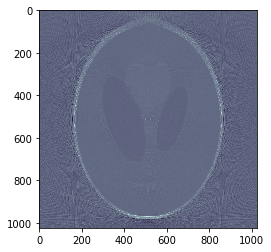

In [178]:

#dataset = pydicom.dcmread(filename)
iradon = projekt1("Shepp_logan.jpg", alfa, n, l, gifFlag=False, filter=True)
plt.imshow(iradon, cmap=plt.cm.bone)
plt.show()

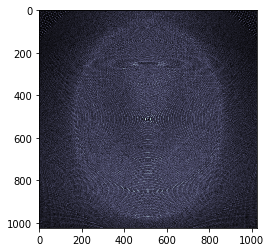

In [90]:
iradon = projekt1("Shepp_logan.jpg", alfa, n, l, filter=False)
plt.imshow(iradon, cmap=plt.cm.bone)
plt.show()

# 4.0

In [46]:
import os
import tempfile
import datetime

import pydicom
from pydicom import dcmread
from pydicom.dataset import Dataset, FileDataset

In [115]:
def write_dicom(array, filename="iradon.dcm", name="Test^Firstname", patientID="123456"):
    # Create some temporary filenames
    print("Setting file meta information...")
    filename_little_endian = tempfile.NamedTemporaryFile(suffix=".dcm").name
    # Populate required values for file meta information
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
    file_meta.MediaStorageSOPInstanceUID = "1.2.3"
    file_meta.ImplementationClassUID = "1.2.3.4"

    print("Setting dataset values...")
    # Create the FileDataset instance (initially no data elements, but file_meta
    # supplied)
    ds = FileDataset(filename_little_endian, {},
                     file_meta=file_meta, preamble=b"\0" * 128)

    # Add the data elements -- not trying to set all required here. Check DICOM
    # standard
    ds.PatientName = name
    ds.PatientID = patientID

    # Set the transfer syntax
    ds.is_little_endian = True
    ds.is_implicit_VR = True

    # Set creation date/time
    dt = datetime.datetime.now()
    ds.ContentDate = dt.strftime('%Y%m%d')
    timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
    ds.ContentTime = timeStr

    # Set pixel array
    ds.PixelData = np.array(array*255, dtype=np.int8).tobytes()
    ds.Rows, ds.Columns = array.shape
    ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    
    ds.PixelRepresentation = 0
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.NumberOfFrames = 1
    ds.PhotometricInterpretation = "MONOCHROME"
    ds.PlanarConfiguration = 0
    
    print("Writing test file", filename_little_endian)
    ds.save_as(filename)
    print("File saved.")

In [116]:
write_dicom(iradon)

Setting file meta information...
Setting dataset values...
Writing test file /tmp/tmpxvy5z1xt.dcm
File saved.


In [117]:
def readDicom(filename="iradon.dcm"):
    ds = dcmread(filename)
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(ds.Rows), int(ds.Columns))

    ArrayDicom = np.zeros(ConstPixelDims, dtype=np.int8)
    ArrayDicom = ds.pixel_array

    plt.imshow(ArrayDicom, cmap=plt.cm.bone)
    plt.show()

    return ArrayDicom

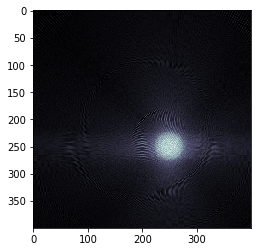

255

In [118]:
x = readDicom()
x.max()

In [119]:
img = plt.imread("Kolo.jpg")
img_gray = img[...,0]/255
write_dicom(np.array(img_gray), "Kolo.dcm")
np.array(img_gray).shape

Setting file meta information...
Setting dataset values...
Writing test file /tmp/tmpaaghybxb.dcm
File saved.


(400, 400)

In [120]:
def projekt1_gray(img_gray, alfa, n, l):
    print(img_gray)
    plt.imshow(img_gray)
    R = (max(img_gray.shape))*2**.5+10 
    radon = radon_iwm(img_gray, alfa, n, l, R)
    plt.imshow(radon, cmap=plt.cm.bone)
    plt.show()
    iradon = inverseRadon_iwn(radon, img_gray.shape, alfa, n, l, R)
    plt.imshow(iradon, cmap=plt.cm.bone)
    plt.show()
    return iradon

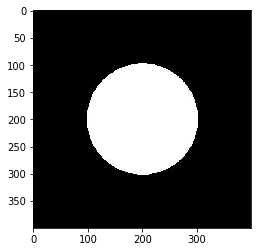

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
imgshape (400, 400)
angle 80
angle 70
angle 60
angle 50
angle 40
angle 30
angle 20
angle 10
angle 0
angle -10
angle -20
angle -30
angle -40
angle -50
angle -60
angle -70
angle -80
angle -90


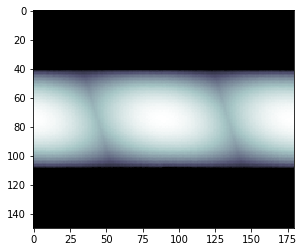

angle 80
angle 70
angle 60
angle 50
angle 40
angle 30
angle 20
angle 10
angle 0
angle -10
angle -20
angle -30
angle -40
angle -50
angle -60
angle -70
angle -80
angle -90
[[0.0782332  0.0518733  0.06787157 ... 0.05033126 0.0677848  0.05173514]
 [0.05053986 0.06364375 0.06296078 ... 0.05686883 0.06306763 0.06526832]
 [0.06698238 0.06233685 0.10023562 ... 0.06118648 0.10043844 0.06677106]
 ...
 [0.05457677 0.08143928 0.02287613 ... 0.10483351 0.01948935 0.08198835]
 [0.06898859 0.03304413 0.10395827 ... 0.01945106 0.10483912 0.03694663]
 [0.08196419 0.08055622 0.03346354 ... 0.08130078 0.03794046 0.07736392]]


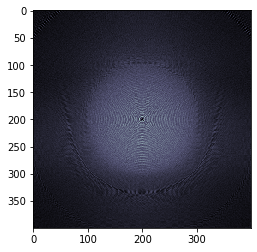

Setting file meta information...
Setting dataset values...
Writing test file /tmp/tmp3evfzz9f.dcm
File saved.


In [125]:
img_gray_d = readDicom(filename="Kolo.dcm")
iradon = projekt1_gray(img_gray_d, alfa, n, l)
write_dicom(iradon, "newIradon.dcm")

# 5.0


### Experiment

In [17]:
from sklearn.metrics import mean_squared_error

In [22]:
img = plt.imread("Shepp_logan.jpg")
y_true = img[...,0]
y_true = y_true / y_true.max()
#mean_squared_error(y_true, y_pred)

In [23]:
n = 180
l = 180
s = 180
alfa = 180/s

liczba detektorów zmienia się od 90 do 720 z krokiem 90,


In [181]:
def exp1(y_true):
    n = 180 
    l = 180
    s = 180
    alfa = 180/s
    nExperiment = {}
    for n in range(90, 721, 90):
        iradon_mse = list()
        filtered_mse = list()
        iradon = projekt1("Shepp_logan.jpg", alfa, n, l,gifFlag=False, filter=True)
        
        print(n)
        
        plt.imshow(iradon, cmap=plt.cm.bone)
        plt.title(f"Iradon image non filtered. n: {n}, l: {l}, alfa:{alfa}")
        plt.savefig(f"./nExperiment/{n}_nonfiltered.jpg")
        
        
        nExperiment[n] = mean_squared_error(y_true, iradon, squared=False)
    return nExperiment

90
180
270
360
450
540
630
720


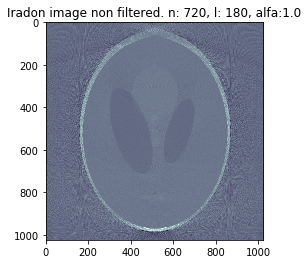

In [182]:
nExperiment = exp1(y_true)

liczba skanów zmienia się od 90 do 720 z krokiem 90

In [212]:
def exp2(y_true):
    n = 180 
    l = 180
    s = 180
    alfa = 180/s
    sExperiment = {}
    for s in range(90, 721, 90):
        iradon_mse = list()
        filtered_mse = list()
        alfa = 180/s
        iradon = projekt1("Shepp_logan.jpg", alfa, n, l,gifFlag=False, filter=False)
        
        print(s)
        
        plt.imshow(iradon, cmap=plt.cm.bone)
        plt.title(f"Iradon image non filtered. n: {n}, l: {l}, alfa:{alfa}")
        plt.savefig(f"./sExperiment/{s}_nonfiltered.jpg")
        
        sExperiment[s] = mean_squared_error(y_true, iradon, squared=False)
    return sExperiment

In [ ]:
sExperiment = exp2(y_true)

90
180
270


rozpiętość wachlarza zmienia się od 45 do 270 stopni z krokiem 45 stopni.

In [ ]:
def exp3(y_true):
    n = 180 
    l = 180
    s = 180
    alfa = 180/s
    lExperiment = {}
    for l in range(45, 271, 45):
        iradon_mse = list()
        iradon= projekt1("Shepp_logan.jpg", alfa, n, l,gifFlag=False, filter=False)
        print(l)
        
        plt.imshow(iradon, cmap=plt.cm.bone)
        plt.title(f"Iradon image non filtered. n: {n}, l: {l}, alfa:{alfa}")
        plt.savefig(f"./lExperiment/{l}_nonfiltered.jpg")
        
        lExperiment[l] = mean_squared_error(y_true, iradon, squared=False)

    return lExperiment

In [ ]:
lExperiment = exp3(y_true)

In [191]:
nExperiment

{90: 0.22589508758884094,
 180: 0.2225170864919747,
 270: 0.21168654857752453,
 360: 0.20700156523668092,
 450: 0.2056504998124158,
 540: 0.20710350195376065,
 630: 0.19846599941594578,
 720: 0.18764833489793334}

In [192]:
lExperiment

{45: 0.24324619631850733,
 90: 0.21242851696132103,
 135: 0.2169997695456174,
 180: 0.2225170864919747,
 225: 0.22419804360619938,
 270: 0.22441244677064862}

In [193]:
sExperiment

{90: 0.22635033765140017,
 180: 0.2225170864919747,
 270: 0.22232789274790388,
 360: 0.2220112448871118,
 450: 0.21977775851904177,
 540: 0.220322113788129,
 630: 0.2191130524776503,
 720: 0.22011649512164208}

/home/i/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


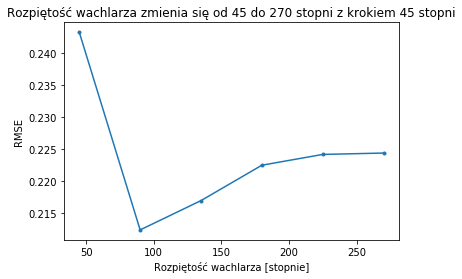

In [209]:
Experiment = lExperiment
fig = plt.figure()
plt.title("Rozpiętość wachlarza zmienia się od 45 do 270 stopni z krokiem 45 stopni")
ax = plt.subplot(111)
plt.plot(list(Experiment.keys()),list(Experiment.values()), '.-' ) 
plt.xlabel('Rozpiętość wachlarza [stopnie]')
plt.ylabel('RMSE')
#ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [ ]:
def exp4(y_true):
    n = 360 
    l = 270
    s = 360
    alfa = 180/s

        
    iradon= projekt1("Shepp_logan.jpg", alfa, n, l,gifFlag=False, filter=False)
    iradon_filtered= projekt1("Shepp_logan.jpg", alfa, n, l,gifFlag=False, filter=True)

    rmse = mean_squared_error(y_true, iradon, squared=False)
    rmse_filtered = mean_squared_error(y_true, iradon_filtered, squared=False)

    plt.imshow(iradon, cmap=plt.cm.bone)
    plt.title(f"Iradon image non filtered. RMSE: {rmse}. n: {n}, l: {l}, alfa:{alfa}")
    plt.savefig(f"./4Experiment/nonfiltered.jpg")
    
    plt.imshow(iradon_filtered, cmap=plt.cm.bone)
    plt.title(f"Iradon image filtered. RMSE: {rmse_filtered}. n: {n}, l: {l}, alfa:{alfa}")
    plt.savefig(f"./4Experiment/filtered.jpg")

    
    return lExperiment

In [ ]:
exp4(y_true)